# Eager Few Shot Object Detection Colab

This notebook is based on TF [Eager Few Shot Object Detection Colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb).

## Imports

In [1]:
import tensorflow as tf

# Set memory growth to prevent OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("Successfully set memory growth")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2022-12-06 21:54:22.047261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 21:54:23.771695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nashirj/miniconda3/lib/
2022-12-06 21:54:23.771951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nashirj/miniconda3/lib/
2022-12-06 21:54:23.771959: W tensorflow/compiler/tf2tensorrt/utils/

Successfully set memory growth


2022-12-06 21:54:25.415041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:54:25.503856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:54:25.504065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:54:25.506298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import glob
import numpy as np

import cv2

from IPython.display import display
from IPython.display import Image as IPyImage

%matplotlib inline

# Utilities

In [4]:
import inference
import utilities

Successfully set memory growth


# Rocket data

We will start with a small set of data consisting of 7 images of a rocket.  Note that the [coco](https://cocodataset.org/#explore) dataset contains airplanes, but it does *not* contain rockets, so this is a novel class.

In [5]:
train_imgs_path = '../data/train_imgs/'
train_img_paths = glob.glob(train_imgs_path + '*.jpg')
train_img_paths.sort()

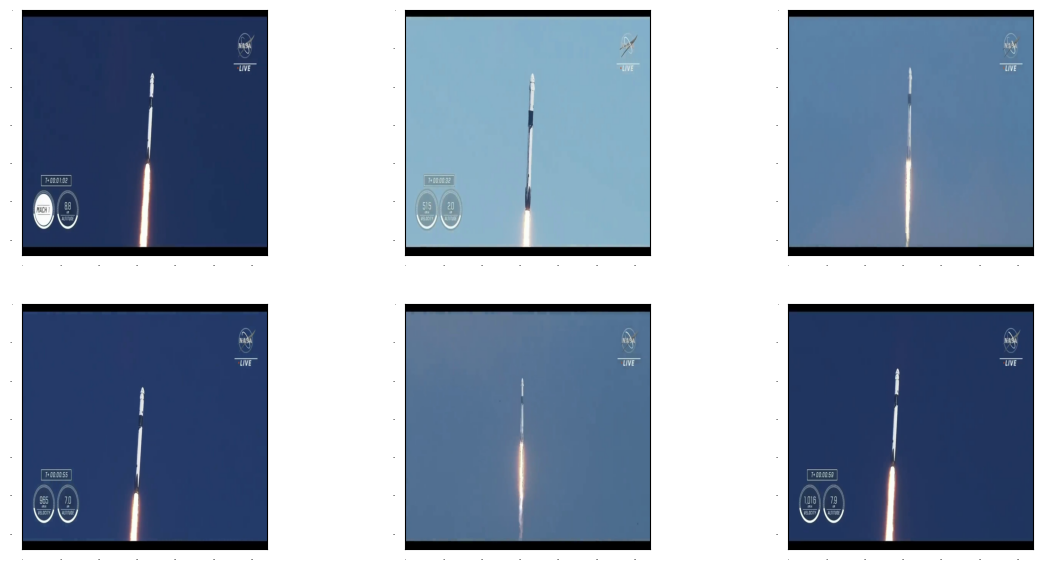

In [8]:
# Load images and visualize
train_images_np = []
for image_path in train_img_paths:
    img = utilities.load_image_into_numpy_array(image_path)
    resized = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
    train_images_np.append(resized)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
    if idx == 5:
        break
plt.show()

# Annotate images with bounding boxes

I used [LabelStudio](https://github.com/heartexlabs/label-studio) to create bounding box annotations in the YOLO format.

In [9]:
train_labels_path = '../data/train_labels/'
train_label_paths = glob.glob(train_labels_path + '*.txt')
train_label_paths.sort()

In [10]:
gt_boxes = utilities.convert_yolo_to_gt(train_label_paths)

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [11]:
num_classes = 1

In [12]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
rocket_class_id = 1

category_index = {rocket_class_id: {'id': rocket_class_id, 'name': 'rocket'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Visualize the rockets with bounding boxes as a sanity check


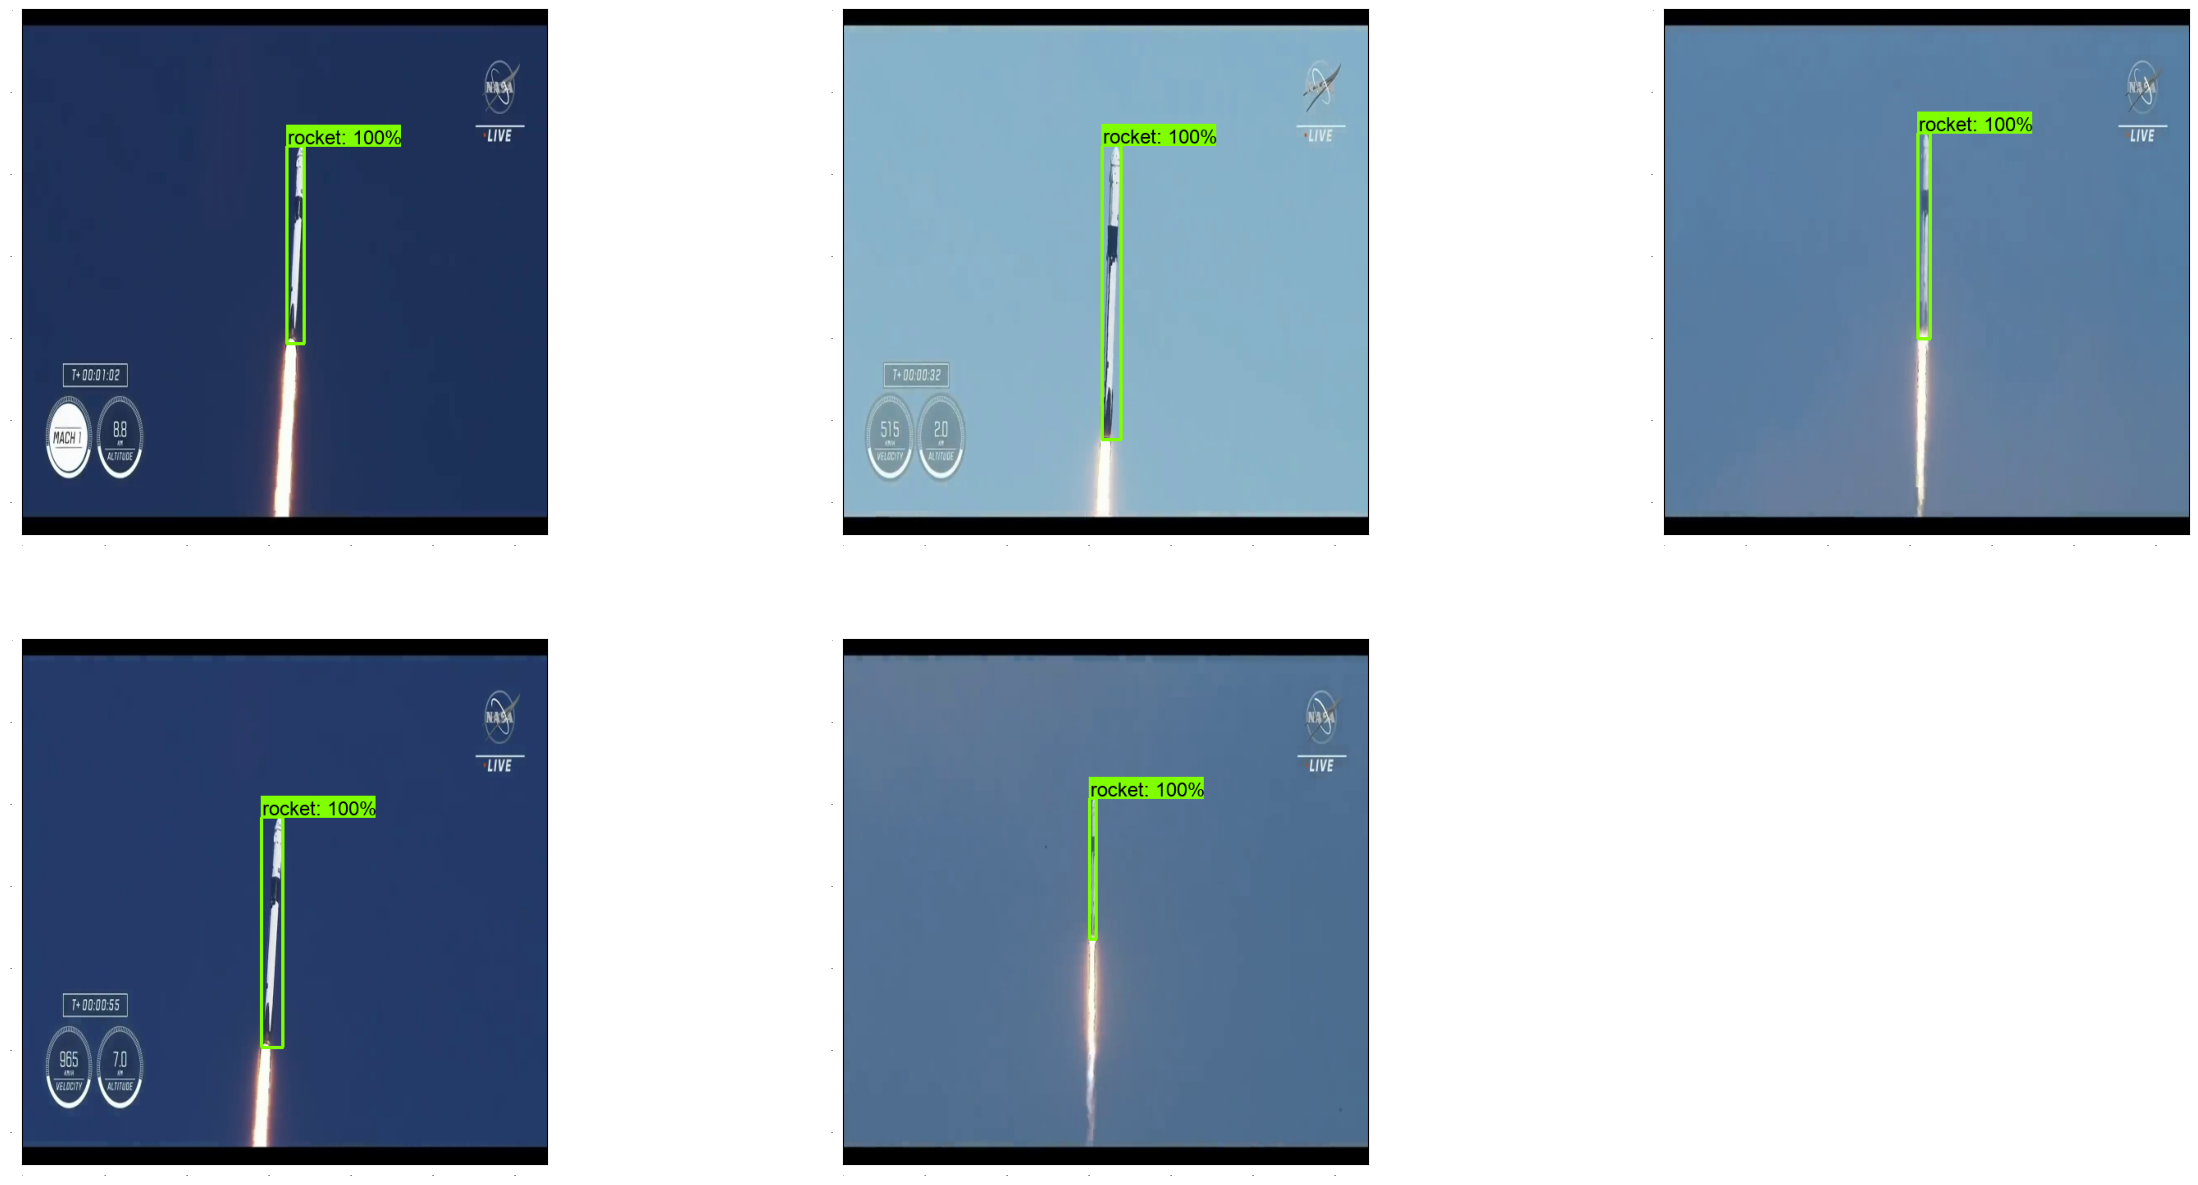

In [13]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, (idx % 6) + 1)
    utilities.plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [55]:
# Path to folder with checkpoint
pipeline_config = '../tf_code/models/research/object_detection/configs/tf2/rocket_model.config'
checkpoint_path = '../od_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

In [56]:
detection_model = utilities.create_model_and_restore_weights_for_train(num_classes, pipeline_config, checkpoint_path)

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



# TODO: Look up how to compute metrics for validation data without updating model and put the code for it here

In [57]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                 for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss, losses_dict['Loss/localization_loss'], losses_dict['Loss/classification_loss']

    return train_step_fn

In [58]:
# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [65]:
overall_loss = []
class_loss = []
localization_loss = []

In [66]:
# Tunable parameters.
batch_size = 4
learning_rate = 0.001
num_batches = 200

In [67]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Best model: train 50 epochs with LR=0.1, 200 epochs with LR=0.001

In [68]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Note that we do not do data augmentation in this demo.  If you want a
    # a fun exercise, we recommend experimenting with random horizontal flipping
    # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss, loc_loss, cls_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    overall_loss.append(total_loss)
    localization_loss.append(loc_loss)
    class_loss.append(cls_loss)

    # TODO: compute loss on validation set (e.g. test data)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 200, loss=1.2849679
batch 10 of 200, loss=0.59216356
batch 20 of 200, loss=0.36220667
batch 30 of 200, loss=0.28294182
batch 40 of 200, loss=0.2205129
batch 50 of 200, loss=0.14066963
batch 60 of 200, loss=0.113920435
batch 70 of 200, loss=0.11754075
batch 80 of 200, loss=0.06441285
batch 90 of 200, loss=0.08268403
batch 100 of 200, loss=0.06260081
batch 110 of 200, loss=0.04287771
batch 120 of 200, loss=0.039185535
batch 130 of 200, loss=0.057446085
batch 140 of 200, loss=0.036549192
batch 150 of 200, loss=0.055938546
batch 160 of 200, loss=0.04009483
batch 170 of 200, loss=0.047928624
batch 180 of 200, loss=0.045415074
batch 190 of 200, loss=0.027669197
Done fine-tuning!


### Vis on training data

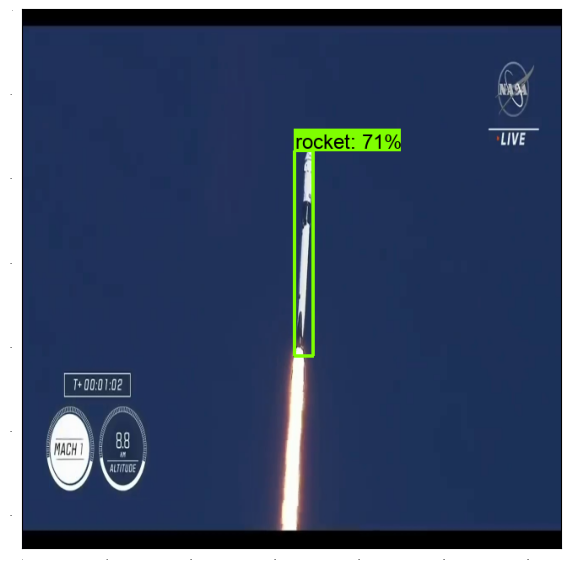

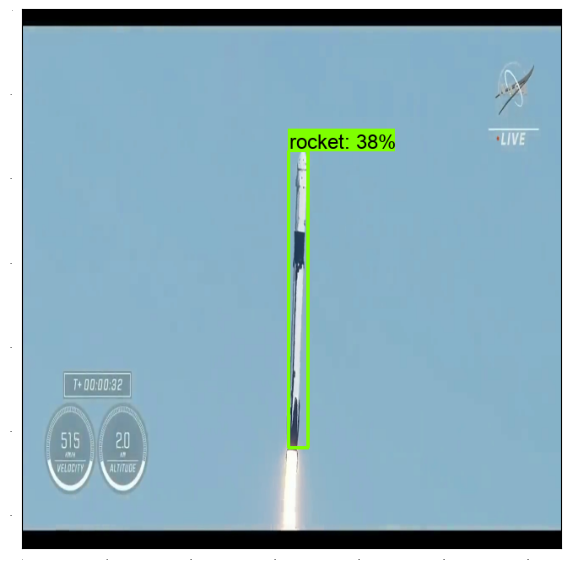

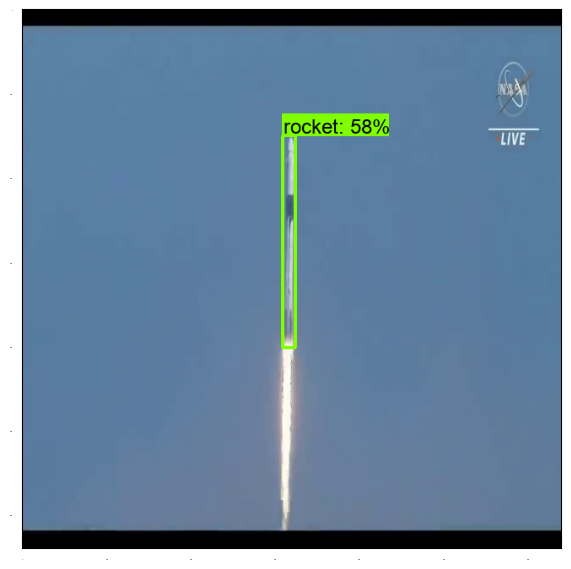

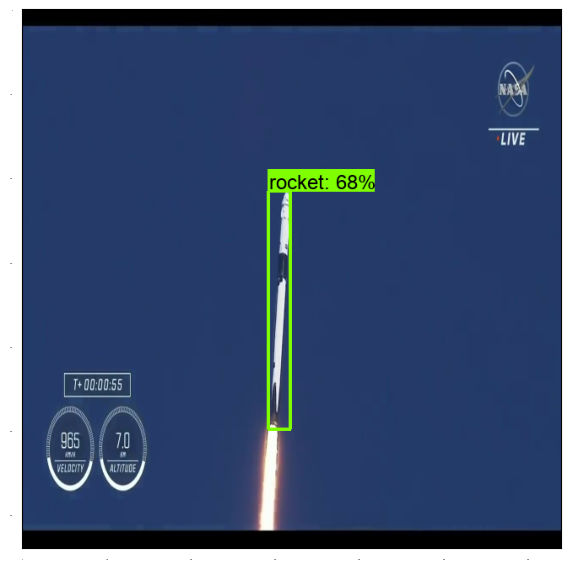

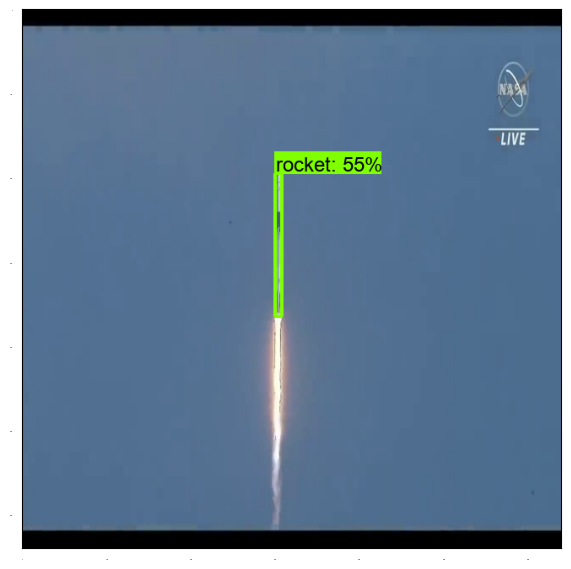

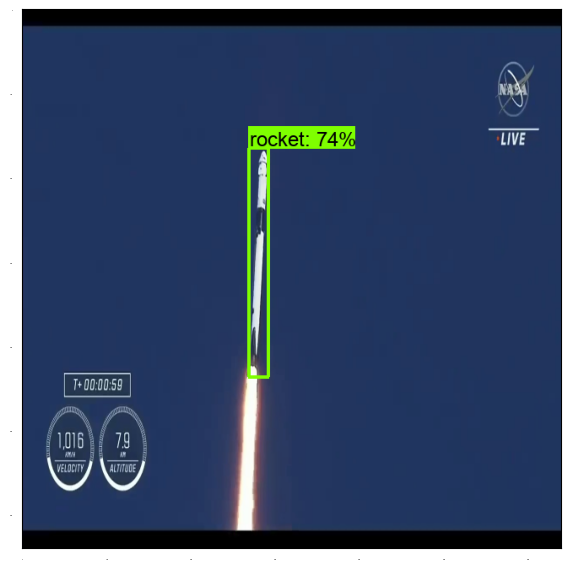

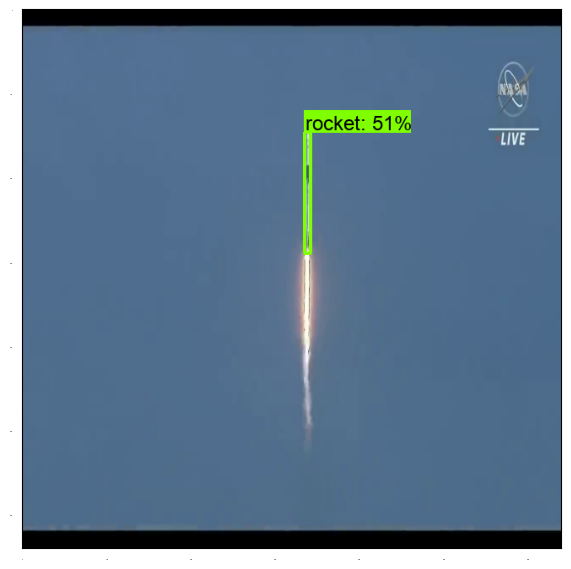

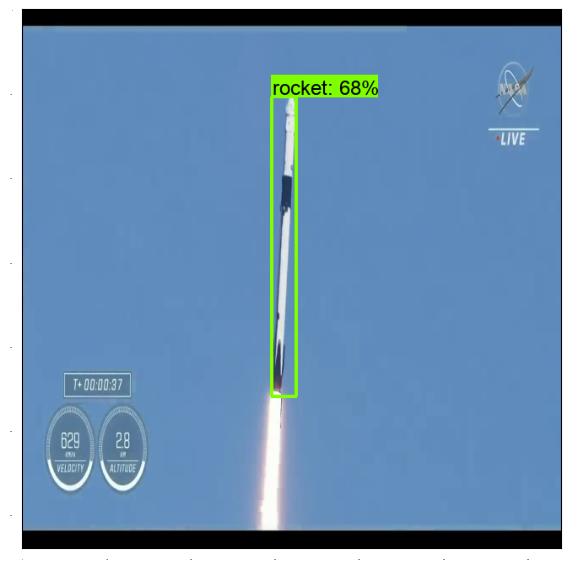

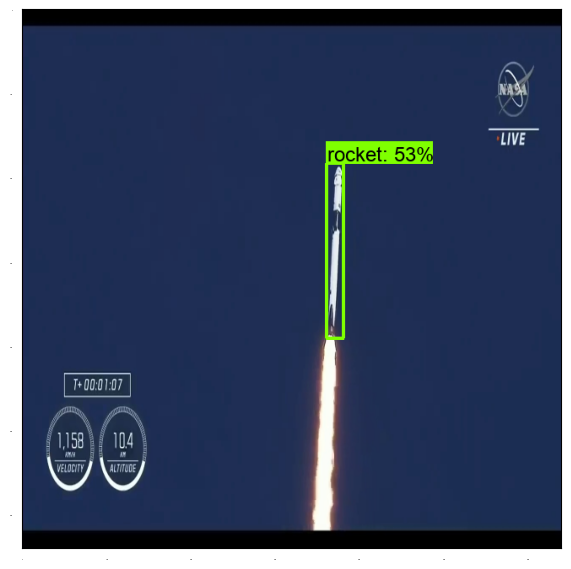

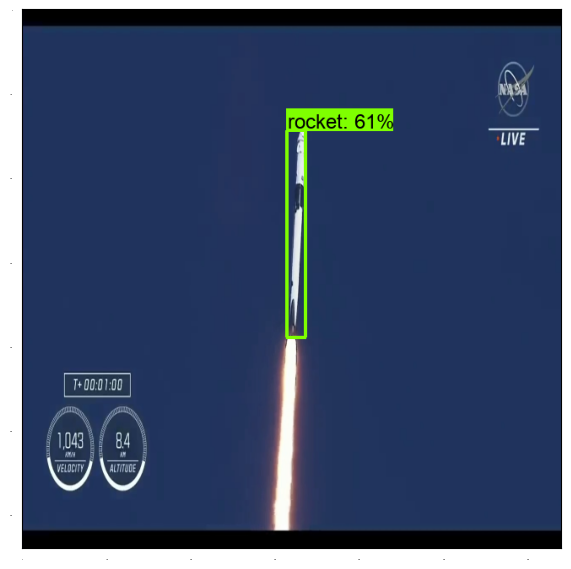

In [70]:
label_id_offset = 1
for i in range(min(len(train_images_np), 10)):
    image_np = train_images_np[i]
    # Note: can take any size input image; automatically converted by preprocess fn in detect
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = inference.detect(detection_model, input_tensor)

    utilities.plot_detections(
        image_np,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), min_score_thresh=0.2)
    plt.show()

## Save loss data

In [71]:
np.savez("../data/metrics/loss-12-6-17:53.npz", localization_loss, class_loss, overall_loss)

# Load test images and run inference!

In [14]:
val_imgs_path = '../data/test_imgs/'
val_img_paths = glob.glob(val_imgs_path + '*.jpg')
val_img_paths.sort()

In [73]:
val_images_np = []
for image_path in val_img_paths:
    img = utilities.load_image_into_numpy_array(image_path)
    resized = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
    val_images_np.append(resized)

# Visualize results on validation data

In [79]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(val_images_np)):
    image_np = val_images_np[i]
    # Note: can take any size input image; automatically converted by preprocess fn in detect
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = inference.detect(detection_model, input_tensor)

    utilities.plot_detections(
        image_np,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), image_name=f"spacex-rocket-annot-{i}.jpg", min_score_thresh=0.2)
    plt.show()

# Save model

In [76]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=detection_model)
manager = tf.train.CheckpointManager(ckpt, "../od_models/rocket_model/", max_to_keep=3)
save_path = manager.save()
save_path

'../od_models/rocket_model/ckpt-1'

# Run on whole video and annotate/save frames

In [18]:
import re

In [19]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [20]:
all_imgs_path = '../data/all-spacex-images/'
all_imgs_paths = glob.glob(all_imgs_path + '*.jpg')
all_imgs_paths.sort(key=natural_keys)

In [95]:
for i, image_path in enumerate(all_imgs_paths):
    image_np = utilities.load_image_into_numpy_array(image_path)
    # Note: can take any size input image; automatically converted by preprocess fn in detect
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = inference.detect(detection_model, input_tensor)

    utilities.plot_detections(
        image_np,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), image_name=f"../data/spacex-images-w-bb/{i}.jpg", min_score_thresh=0.2)
